In [2]:
devtools::install_github(repo="Open-EO/openeo-r-client",ref="v0.4.1",dependencies=TRUE)

backports (1.1.3  -> 1.1.4  ) [CRAN]
curl      (3.3    -> 4.0    ) [CRAN]
digest    (0.6.18 -> 0.6.20 ) [CRAN]
ellipsis  (NA     -> 0.2.0.1) [CRAN]
evaluate  (0.12   -> 0.14   ) [CRAN]
highr     (0.7    -> 0.8    ) [CRAN]
httr      (1.4.0  -> 1.4.1  ) [CRAN]
knitr     (1.21   -> 1.24   ) [CRAN]
markdown  (0.9    -> 1.1    ) [CRAN]
mime      (0.6    -> 0.7    ) [CRAN]
openssl   (1.3    -> 1.4.1  ) [CRAN]
pillar    (1.3.1  -> 1.4.2  ) [CRAN]
praise    (NA     -> 1.0.0  ) [CRAN]
Rcpp      (1.0.1  -> 1.0.2  ) [CRAN]
rlang     (0.3.4  -> 0.4.0  ) [CRAN]
sys       (3.2    -> 3.3    ) [CRAN]
testthat  (NA     -> 2.2.1  ) [CRAN]
tibble    (2.1.1  -> 2.1.3  ) [CRAN]
vctrs     (NA     -> 0.2.0  ) [CRAN]
xfun      (0.4    -> 0.9    ) [CRAN]
zeallot   (NA     -> 0.1.0  ) [CRAN]


Installing 21 packages: backports, curl, digest, ellipsis, evaluate, highr, httr, knitr, markdown, mime, openssl, pillar, praise, Rcpp, rlang, sys, testthat, tibble, vctrs, xfun, zeallot
Installing packages into ‘/home/dainius/R/x86_64-redhat-linux-gnu-library/3.5’
(as ‘lib’ is unspecified)


✔  checking for file ‘/tmp/Rtmp6hD5s2/remotesfec4644236b/Open-EO-openeo-r-client-33a3f57/DESCRIPTION’ (458ms)
─  preparing ‘openeo’:
✔  checking DESCRIPTION meta-information ...
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘openeo_0.4.1.tar.gz’
   


Installing package into ‘/home/dainius/R/x86_64-redhat-linux-gnu-library/3.5’
(as ‘lib’ is unspecified)


In [4]:
library(openeo)
conn = connect(host="https://earthengine.openeo.org/", version="0.4.2", user=NA,password=NA,login_type="basic")

Connected to host
Login successful.

In [10]:
# list collection and processes
list_collections(conn)

                                                      id
1                                               AAFC/ACI
2                                      ASTER/AST_L1T_003
3                                 AU/GA/AUSTRALIA_5M_DEM
4                                      CAS/IGSNRR/PML/V2
5   CIESIN/GPWv411/GPW_Basic_Demographic_Characteristics
6                    CIESIN/GPWv411/GPW_Population_Count
7                  CIESIN/GPWv411/GPW_Population_Density
8     CIESIN/GPWv411/GPW_UNWPP-Adjusted_Population_Count
9   CIESIN/GPWv411/GPW_UNWPP-Adjusted_Population_Density
10                         CIESIN/GPWv4/population-count
11                       CIESIN/GPWv4/population-density
12          CIESIN/GPWv4/unwpp-adjusted-population-count
13        CIESIN/GPWv4/unwpp-adjusted-population-density
14                        COPERNICUS/CORINE/V18_5_1/100m
15                                     COPERNICUS/S1_GRD
16                                         COPERNICUS/S2
17                             

In [11]:
list_processes(conn)

$absolute
Process:	absolute
Summary:	Absolute value
Description:	Computes the absolute value of a real number `x`, which is the "unsigned" portion of x and often denoted as *|x|*.

The no-data value `null` is passed through and therefore gets propagated.
Returns:	The computed absolute value.

  Parameter Description Required
1         x   A number.     TRUE

$add_dimension
Process:	add_dimension
Summary:	Add a new dimension
Description:	Adds a new named dimension to the data cube.

Afterwards, the dimension can be referenced with the specified `name`. If a dimension with the specified name exists, the process fails with a `DimensionExists` error. The dimension value of the dimension is set to the specified `value`.
Returns:	The data cube with a newly added dimension.

  Parameter                                 Description Required
1      data        A data cube to add the dimension to.     TRUE
2      name                     Name for the dimension.     TRUE
3     value  A dimension v

In [13]:
# get detailed descriptions
describe_collection(conn, "COPERNICUS/S2")

COPERNICUS/S2
Title:				Sentinel-2 MSI: MultiSpectral Instrument, Level-1C
Description:			Sentinel-2 is a wide-swath, high-resolution, multi-spectral
imaging mission supporting Copernicus Land Monitoring studies,
including the monitoring of vegetation, soil and water cover,
as well as observation of inland waterways and coastal areas.

The Sentinel-2 data contain 13 UINT16 spectral bands representing
TOA reflectance scaled by 10000. See the [Sentinel-2 User Handbook](https://sentinel.esa.int/documents/247904/685211/Sentinel-2_User_Handbook)
for details. In addition, three QA bands are present where one
(QA60) is a bitmask band with cloud mask information. For more
details, [see the full explanation of how cloud masks are computed.](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-1c/cloud-masks)

Each Sentinel-2 product (zip archive) may contain multiple
granules. Each granule becomes a separate Earth Engine asset.
EE asset ids for Sentinel-2 assets have the 

In [14]:
describe_process(conn, "filter_bbox")

Process:	filter_bbox
Summary:	Spatial filter using a bounding box
Description:	Limits the data cube to the specified bounding box.

The filter retains a pixel in the data cube if the point at the pixel center intersects with the bounding box (as defined in the Simple Features standard by the OGC).
Returns:	A data cube restricted to the bounding box. Therefore, the cardinality is potentially lower, but the resolution and the number of dimensions are the same as for the original data cube.

  Parameter
1      data
2    extent
                                                                                                                                                                                                                   Description
1                                                                                                                                                                                                                 A data cube.
2 A bounding box, which 

In [44]:
# create a process graph / task
pgb = process_graph_builder(conn)

data1 = pgb$load_collection(id = pgb$data$`COPERNICUS/S2`,
                              spatial_extent = list(west=-2.7634,south=43.0408,east=-1.121,north=43.8385),
                              temporal_extent = c("2018-04-30","2018-06-26"),bands = c("B4","B8"))
b4 = pgb$filter_bands(data = data1,bands = "B4")
b8 = pgb$filter_bands(data=data1,bands = "B8")

In [45]:
ndvi = pgb$normalized_difference(band1 = b8,band2 = b4)

In [46]:
reducer = pgb$reduce(data = ndvi,dimension = "temporal")
cb_graph = callback(conn, reducer, parameter = "reducer")
cb_graph$setFinalNode(cb_graph$min(data = cb_graph$data$data))

[1] TRUE

In [47]:
apply_linear_transform = pgb$apply(data = reducer)
cb2_graph = callback(conn, apply_linear_transform, "process")
cb2_graph$setFinalNode(cb2_graph$linear_scale_range(x = cb2_graph$data$x,
                                                    inputMin = -1, inputMax = 1,outputMin = 0,outputMax = 255))

[1] TRUE

In [48]:
pgb$setFinalNode(pgb$save_result(data = apply_linear_transform,format = "png"))

[1] TRUE

In [49]:
jsonlite::toJSON(pgb$serialize(), pretty=TRUE)

{
  "load_collection_QHERQ1446J": {
    "process_id": ["load_collection"],
    "arguments": {
      "id": ["COPERNICUS/S2"],
      "spatial_extent": {
        "west": [-2.7634],
        "south": [43.0408],
        "east": [-1.121],
        "north": [43.8385]
      },
      "temporal_extent": [
        ["2018-04-30"],
        ["2018-06-26"]
      ],
      "bands": [
        ["B4"],
        ["B8"]
      ]
    }
  },
  "filter_bands_OKKNR0337R": {
    "process_id": ["filter_bands"],
    "arguments": {
      "data": {
        "from_node": ["load_collection_QHERQ1446J"]
      },
      "bands": [
        ["B4"]
      ]
    }
  },
  "filter_bands_NDKKL2860V": {
    "process_id": ["filter_bands"],
    "arguments": {
      "data": {
        "from_node": ["load_collection_QHERQ1446J"]
      },
      "bands": [
        ["B8"]
      ]
    }
  },
  "normalized_difference_MIUYD7636T": {
    "process_id": ["normalized_difference"],
    "arguments": {
      "band1": {
        "from_node": ["filter_ban

In [50]:
(job_id = create_job(conn, graph=pgb, title="Example graph", description="This graph is just a general example",format="png"))

Job was sucessfully registered on the backend.


[1] "6zEF1eBY9KQ9sShv"

In [51]:
start_job(conn, job_id)

Job '6zEF1eBY9KQ9sShv' has been successfully queued for evaluation.


In [53]:
list_results(conn, job_id)

$id
[1] "6zEF1eBY9KQ9sShv"

$title
[1] "Example graph"

$description
[1] "This graph is just a general example"

$updated
[1] "2019-09-06T15:46:08Z"

$links
$links[[1]]
$links[[1]]$href
[1] "https://earthengine.openeo.org/v0.4/storage/6zEF1eBY9KQ9sShv/0926d949b558e885.png"

$links[[1]]$type
[1] "image/png"

In [54]:
download_results(conn, job = job_id, folder = ".")

In [56]:
(ResultFile = list.files(pattern=glob2rx("*.png")))

[1] "0926d949b558e885.png"

In [38]:
install.packages("magick")

Installing package into ‘/home/dainius/R/x86_64-redhat-linux-gnu-library/3.5’
(as ‘lib’ is unspecified)


In [57]:
library(magick)

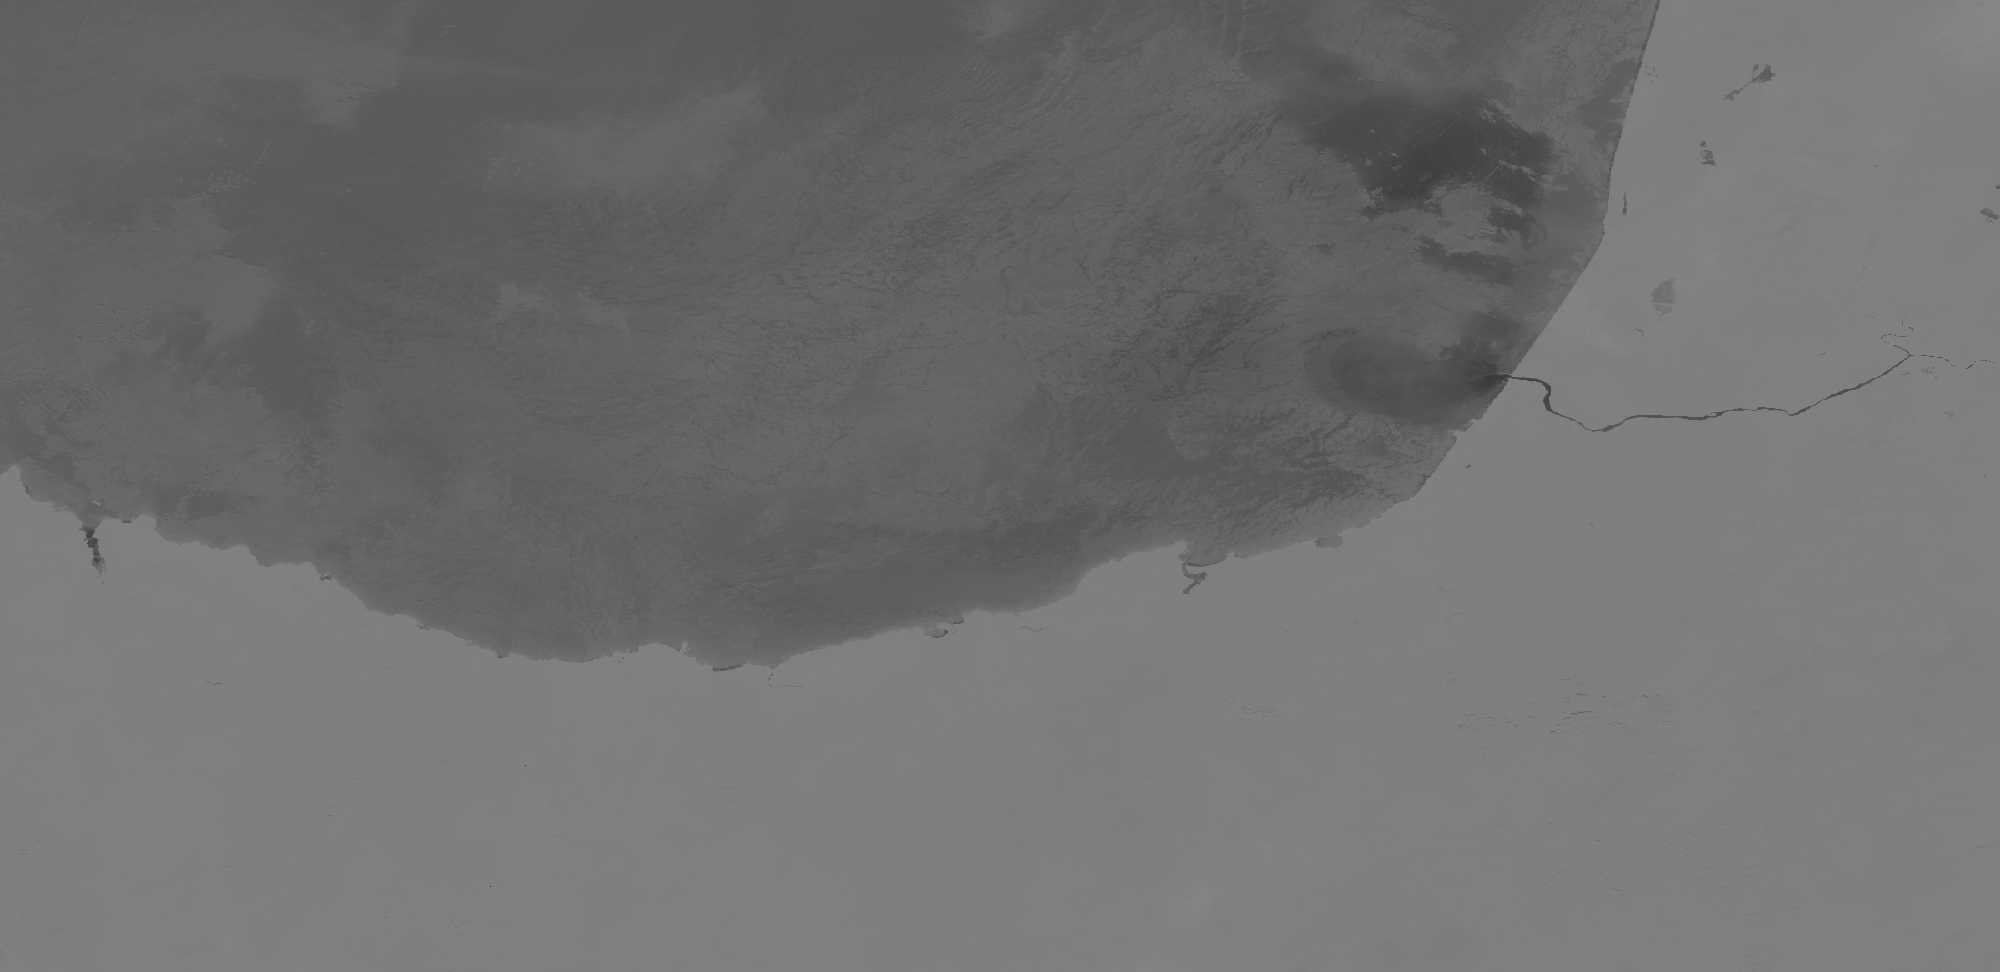

  format width height colorspace matte filesize density
1    PNG  2000    972       Gray FALSE   577577   72x72


In [58]:
ResultPlot = image_read(ResultFile)
print(ResultPlot)

In [59]:
rm(ResultPlot)
file.remove(ResultFile)

[1] TRUE